## Downloads and installations

In [0]:
## - Download `fasttext` model parameters
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

In [0]:
!gunzip "cc.en.300.bin.gz" -d ./ft
!mv ./ft/cc.en.300.bin ./ft/ft.en.bin

gzip: ./ft is a directory -- ignored
mv: cannot stat './ft/cc.en.300.bin': No such file or directory


In [0]:
## - `allennlp` provides pytorch impl of ELMo
!pip install --quiet allennlp
!pip install --quiet tqdm

In [0]:
## - Clone and install python bindings for FastText
!git clone https://github.com/facebookresearch/fastText.git
!pip --quiet install ./fastText

## Demo 1: Encoding Similarity and Confusion

In [0]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

from fastText import FastText as ft
from allennlp.commands.elmo import ElmoEmbedder

from tqdm import tqdm

In [0]:
## - Prepare ELMo model
elmo = ElmoEmbedder(cuda_device=0)

In [0]:
## - Prepare fasttext model
fts = ft.load_model('./ft/ft.en.bin')

In [0]:
## - Some sentences with similar words
sentences_ = [
    'i like you',
    'i love you',
    'i do not dislike you',
    'i do not like you',
    'i hate you',
    'i blahblah you',
]

## With punctuation
# sentences_ = [
#     'May I return , Aunt ?',
#     'I return in May , Aunt .',
#     'Aunt May returns .',
#     'Return , Aunt May .',
# ]

## Punctuation stripped
# sentences_ = [
#     'May I return Aunt',
#     'I return in May Aunt',
#     'Aunt May return',
#     'Return Aunt May'
# ]

sentences_ = list(map(str.lower, sentences_))
sentences = list(map(str.split, sentences_))

- Encode words by **method**
- Encode sentence as arithmetic mean of words encodings

In [0]:
elmos = list(map(elmo.embed_sentence, sentences))

## Dim 0 iterates over the layers in the deep contextual
## representation of ELMo
## Dim 0 iterates over the words in each sentence
elmos = np.array(list(map(lambda x: x.mean((0,1)).reshape(-1), elmos)))

fte = list(map(fts.get_sentence_vector, sentences_))

### Cosine similarity

In [0]:
#@title Plotting utils [code; double click to view]
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
seaborn.set()
  
def plot_confusion(x, ticks=None):

  def heatmap(cm, ticks, **kw):
      '''
      Quick 'n' dirty
      '''
      seaborn.set(rc={'figure.figsize':(6, 6)}, font_scale=1.2)
      ax = seaborn.heatmap(cm, # vmin=0, vmax=1,
                      xticklabels=ticks, yticklabels=ticks, robust=True, annot=True, square=False, cmap='YlGnBu', **kw)
      ax.xaxis.tick_top()
      plt.setp(ax.get_xticklabels(), visible=True, rotation=90)
      plt.setp(ax.get_yticklabels(), visible=True, rotation=0)
      return ax
    
  return heatmap(x, ticks or range(len(x)))

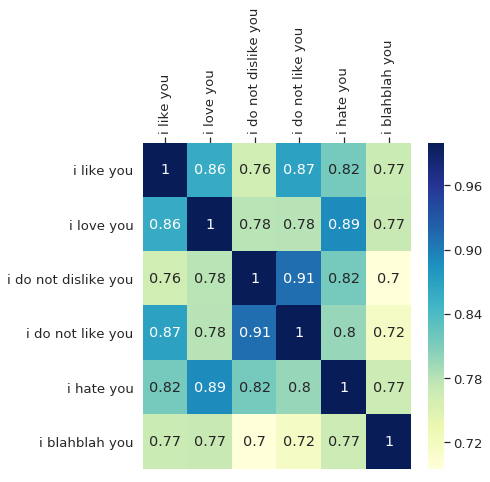

In [0]:
# ELMo
plot_confusion(1 - squareform(pdist(elmos, 'cosine')), sentences_)
plt.show()

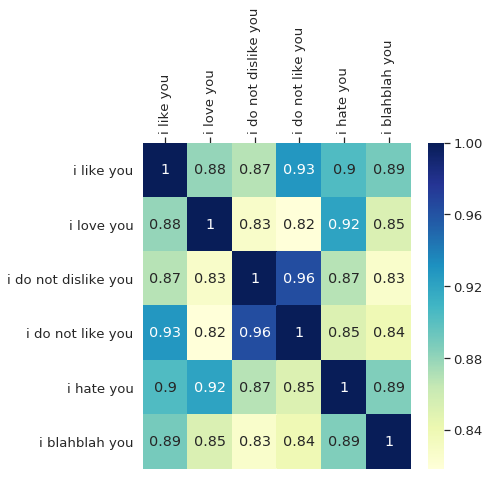

In [0]:
# FastText
plot_confusion(1 - squareform(pdist(fte, 'cosine')), sentences_)
plt.show()

## Demo 2: Text Classification

### Sentiment Analysis

In [0]:
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -P ./data/sentiment
!unzip ./data/sentiment/stanfordSentimentTreebank.zip -d ./data/sentiment

In [0]:
#@title Data Loading [code; double click to view]
def load_data():
  ## Sentences
  data = []
  with open('./data/sentiment/stanfordSentimentTreebank/datasetSentences.txt',
            'rt') as fp:
    fp.readline()
    for line in fp:
      data.append(line.partition('\t')[2].strip())
  data_ = np.array(data)

  ## Labels
  labels = []
  with open('./data/sentiment/stanfordSentimentTreebank/sentiment_labels.txt',
            'rt') as fp:
    fp.readline()
    for line in fp:
      labels.append(line.partition('|')[2].strip())
  labels_ = np.array(labels, dtype=float)

  ## Split suggested by dataset authors
  split = {
      '1': [], # Train
      '2': [], # Val
      '3': [], # Test
  }
  with open('./data/sentiment/stanfordSentimentTreebank/datasetSplit.txt',
            'rt') as fp:
    fp.readline()
    for line in fp:
      index, bucket = line.strip().split(',')
      split[bucket].append(int(index) - 1)
      
  split['train'] = split.pop('1')
  split['val'] = split.pop('2')
  split['test'] = split.pop('3')
  
  return data_, labels_, split

In [0]:
data_, labels_, split = load_data()

In [0]:
## Actually split

# data_train = data_[split['train']]
# data_test = data_[split['test']]

levels = 3
labels = np.clip((labels_ * levels), a_min=0, a_max=levels-1).astype(int)
labels_train = labels[split['train']]
labels_test = labels[split['val']]

In [0]:
# Xdata = list(map(fts.get_sentence_vector, map(str.lower, tqdm(data_))))

def tokenize(s):
  return s.lower().split()

Xdata = elmo.embed_sentences(map(tokenize, tqdm(data_)))
Xdata = list(map(lambda x: x.mean((0, 1)).reshape(-1), Xdata))

Xdata = np.vstack(Xdata)

Xdata.shape

100%|██████████| 11855/11855 [01:00<00:00, 195.90it/s]


(11855, 1024)

In [0]:
Xtrain = Xdata[split['train']]
Xtest = Xdata[split['val']]

#### Logistic Regression

In [0]:
from torch import nn
import torch

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        x = self.linear(x)
        x = torch.softmax(x, -1)
        return x

In [0]:
def demo():
  inp = Xtrain
  input_size = inp.shape[-1]

  num_epochs = 50
  learning_rate = 1e-4

  model = LogisticRegression(input_size, num_classes=levels)

  # Loss and Optimizer
  # Softmax is internally computed.
  # Set parameters to be updated.
  criterion = nn.CrossEntropyLoss()  
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
      embs = Xtrain
      ilabels = labels_train
      embs = torch.Tensor(embs)
      ilabels = torch.LongTensor(ilabels)

      # Forward + Backward + Optimize
      optimizer.zero_grad()
      outputs = model(embs)

      loss = criterion(outputs, ilabels)
      loss.backward()
      optimizer.step()

      end = ''
      if epoch == 0 or (epoch >= 5 and epoch % 5 == 0):
        end = '\n'
        
      acc = 100 * np.mean(np.argmax(outputs.detach().numpy(), axis=1) == labels_train)
      acc = f'{acc:0.4f}%'
      msg = f'Epoch: [{epoch+1:>4}/{num_epochs}], Loss: {loss.item():.4f}'
      print ('\r' + msg, ';', acc, end=end)
      
      if end == '\n':
        test = model(torch.Tensor(Xtest))
        acc = 100 * np.mean(np.argmax(test.detach().numpy(), axis=1) == labels_test)
        print(f'Validation Results: {acc:.4f}%\n')

##### Results

In [0]:
## ELMo
demo()

Epoch: [   1/50], Loss: 1.0974 ; 35.5103%
Validation Results: 39.6833%

Epoch: [   6/50], Loss: 1.0845 ; 53.6049%
Validation Results: 54.3439%

Epoch: [  11/50], Loss: 1.0715 ; 63.0033%
Validation Results: 63.3937%

Epoch: [  16/50], Loss: 1.0586 ; 65.6835%
Validation Results: 64.6606%

Epoch: [  21/50], Loss: 1.0460 ; 66.4911%
Validation Results: 65.2489%

Epoch: [  26/50], Loss: 1.0337 ; 66.5379%
Validation Results: 65.4751%

Epoch: [  31/50], Loss: 1.0218 ; 66.5847%
Validation Results: 65.5204%

Epoch: [  36/50], Loss: 1.0106 ; 66.5847%
Validation Results: 65.5204%

Epoch: [  41/50], Loss: 1.0001 ; 66.5847%
Validation Results: 65.5204%

Epoch: [  46/50], Loss: 0.9904 ; 66.5847%
Validation Results: 65.5204%

Epoch: [  50/50], Loss: 0.9832 ; 66.5847%

In [0]:
## FastText
demo()

Epoch: [   1/50], Loss: 1.0988 ; 17.2636%
Validation Results: 17.0136%

Epoch: [   6/50], Loss: 1.0979 ; 17.8488%
Validation Results: 17.7828%

Epoch: [  11/50], Loss: 1.0970 ; 20.6110%
Validation Results: 20.5882%

Epoch: [  16/50], Loss: 1.0962 ; 29.7402%
Validation Results: 30.8145%

Epoch: [  21/50], Loss: 1.0953 ; 44.7331%
Validation Results: 45.6561%

Epoch: [  26/50], Loss: 1.0944 ; 57.7832%
Validation Results: 56.4253%

Epoch: [  31/50], Loss: 1.0935 ; 63.4363%
Validation Results: 62.6244%

Epoch: [  36/50], Loss: 1.0927 ; 65.5782%
Validation Results: 64.7511%

Epoch: [  41/50], Loss: 1.0918 ; 66.0698%
Validation Results: 65.0679%

Epoch: [  46/50], Loss: 1.0909 ; 66.3624%
Validation Results: 65.3846%

Epoch: [  50/50], Loss: 1.0902 ; 66.4677%